In [13]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emoji
import collections
import seaborn as sns
import datetime
import pytz
import plotly.graph_objects as go
from nltk.stem import LancasterStemmer
%matplotlib inline

In [14]:
# Reading the whatsApp text file
file = open(r'./WhatsApp Chat with Stardust.txt',mode='r',encoding="utf8")
data = file.read()
file.close()
#data

In [15]:
# utility function for accepting the format of date:
def valid_date(datestring):
        try:
                mat=re.match('(\d{1,2})[/.-](\d{1,2})[/.-](\d{2,4})$', datestring)
                if mat is not None:
                        #datetime.datetime(*(map(int, mat.groups()[-1::-1])))
                        return True
        except ValueError:
                pass
        return False

In [16]:
# reading the text file and getting each individual messages and their details in the form of lists:
lines = []
with open('chat.txt',mode='r',encoding='utf8') as f:
    for line in f:
        if valid_date(line.split(',')[0]):
            lines.append(line.strip('\n'))
        else:
            lines[len(lines) - 1] += ' ' + line.strip('\n')

In [17]:
del lines[0]

In [18]:
print(len(lines))

2483


In [19]:
# just a hack for automating the format of year in the date which goes as a parameter in the strptime function:
temp=lines[0]
temp=temp.split(', ')[0]
temp=temp[::-1]
cnt=0
for i in temp:
    cnt+=1
    if(i=='/'):
        break
cnt-=1
if(cnt==2):
    yr='y'
else:
    yr='Y'

In [20]:
def valid_user(lsts):
    if len(lsts) == 5 and not 'changed' in lsts[-1] and not 'left' in lsts[-1] and not 'added' in lsts[-1] and not 'created' in lsts[-1] and not 'removed' in lsts[-1] and not 'admin' in lsts[-1]:
        return True
    elif '+91' in lsts[-1] and len(lsts) <= 3:
        return True
    return False

In [21]:
# defining the regex pattern for grabbing information from the list 'lines' we created:
pattern2 = re.compile('(\d?\d+:\d\d)+\s+(pm|am|PM|AM)+\s+-\s+([a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?):\s+')

In [22]:
# extracting all necessary details of a specific message for creating a well structured dataframe:
dates=[]
datetimes=[]
times=[]
msgs=[]
messengers=[]
#frmat='%d/%m/%Y'
for each in lines:
    lsts=pattern2.split(each)
#     print(lsts)
    if(not valid_user(lsts)):
        continue
    x=lsts[0].split(', ')[0]
    dates.append(x)
    times.append(lsts[1]+' '+lsts[2]) 
    pat=x+', '+lsts[1]+' '+lsts[2]
    datetimes.append(datetime.datetime.strptime(pat, '%d/%m/%'+yr+', %I:%M %p'))
    msgs.append(lsts[4])
    messengers.append(lsts[3])

In [23]:
names=[y for y in np.unique(messengers)]  # obtaining the names of the participants as list.
names

['Naman Rastogi', 'Omega']

In [24]:
# Move your name at the end of the list:
my_name='Omega'
idx=1
for i in range(len(names)):
    if(names[i].lower()==my_name.lower()):
        idx=i
        break
names.sort(key=names[idx].__eq__) 
names

['Naman Rastogi', 'Omega']

In [25]:
# counts of messages by all participants of the chat in an ordered dictionary (having the keys(or names) 
# in same order as that in the list).
count_messages=collections.OrderedDict()
for i in names:
    for each in messengers:
        if(i.lower()==each.lower()):
            if each in count_messages.keys():
                count_messages[i]+=1
            else:
                count_messages[i]=1
count_messages

OrderedDict([('Naman Rastogi', 1548), ('Omega', 933)])

In [26]:
# total messages of the chat: 
total=0
for each in count_messages:
    total=total+count_messages[each]
print('Total messages exchanged: '+str(total))

Total messages exchanged: 2481


In [27]:
# defining our dataframe:
data_df=pd.DataFrame(columns=['datetime','time','name','messages','date','day','month','year','count'])
data_df

,datetime,time,name,messages,date,day,month,year,count


In [28]:
# filling the dataframe with values:
data_df['datetime']=datetimes
data_df['time']=times
data_df['name']=messengers
data_df['messages']=msgs
data_df['date'] = data_df['datetime'].apply(lambda x: x.date())
data_df['day'] = data_df['datetime'].dt.strftime('%a')
data_df['month'] = data_df['datetime'].dt.strftime('%b')
data_df['year'] = data_df['datetime'].dt.year
data_df['count'] = 1

In [49]:
data_df.head(2)

,datetime,time,name,messages,date,day,month,year,count,msg_length,is_media,hour_sent
0,2018-09-07 18:51:00,6:51 pm,Naman Rastogi,Heyy!!,2018-09-07,Fri,Sep,2018,1,6,0,18
1,2018-09-07 18:52:00,6:52 pm,Omega,hi,2018-09-07,Fri,Sep,2018,1,2,0,18


In [50]:
# Separate the messages of every participant and append them one after another:
sep_msgs=[]
for each in count_messages.keys():
    for msg in range(len(msgs)):
        if each == messengers[msg]:
            sep_msgs.append(msgs[msg])   #obtaining the message corresponding to the participant who sent it.b
print(len(sep_msgs))   

2481


In [51]:
# Creating another dataframe with columns as names of the participants and the rows containing there messages
who_sent_what = []
prev = 0
for each in count_messages.keys():
    num = count_messages[each]
    
    nex = num+prev
    messages = sep_msgs[prev:nex]
    who_sent_what.append(messages)
    prev = nex
who_sent_what
msg_df=pd.DataFrame(who_sent_what)
msg_df = msg_df.transpose()
msg_df.columns = [y for y in names]

In [52]:
# getting the information of message deletions:
xlast_del=0;
for i in msg_df.iloc[:,-1]:
    if(i=='You deleted this message'):
        xlast_del+=1
print('Messages deleted by '+'{}'.format(names[-1]) +': '+str(xlast_del))
xi_del=0
for i in range(len(names)-1):
    xi_del=0
    for j in msg_df.iloc[:,i]:
        if(j=='This message was deleted'):
            xi_del+=1
    print('Messages deleted by '+'{}'.format(names[i]) +': '+str(xi_del)) 

Messages deleted by Omega: 37
Messages deleted by Naman Rastogi: 8


In [53]:
# getting information of media exahnges:
xlast_media=0;
for i in msg_df.iloc[:,-1]:
    if(i=='<Media omitted>'):
        xlast_media+=1
print('Media files sent by '+'{}'.format(names[-1]) +': '+str(xlast_media))
xi_media,xi_tot=0,0
for i in range(len(names)-1):
    xi_media=0
    for j in msg_df.iloc[:,i]:
        if(j=='<Media omitted>'):
            xi_media+=1
    xi_tot+=xi_media
    print('Media files sent by '+'{}'.format(names[i])+': '+str(xi_media))
print('Total media exhachanged: '+str(xlast_media+xi_tot))

Media files sent by Omega: 89
Media files sent by Naman Rastogi: 196
Total media exhachanged: 285


In [54]:
# defining the helper function to extract emojis:
def extract_emojis(columnname):
    emojis=[]
    for string in msg_df[columnname]:
        my_str = str(string)
        for each in my_str:
            if each in emoji.UNICODE_EMOJI:
                emojis.append(each)
    return emojis

In [55]:
# Getting the emojis sent by each participant and their corresponding count
emoji_dict={}
top5_emj=collections.OrderedDict()
tot_emj=collections.OrderedDict()
#emoji_df=pd.DataFrame()
emoji_all=pd.DataFrame(columns=['name','emojis_used'])
emoji_all['name']=names
t=0
d={}

for keys in count_messages.keys():
    print(keys)
    emoji_dict[keys] = extract_emojis(keys)
    emoji_df=pd.DataFrame(emoji_dict[keys])
    d={}
    x=emoji_df[0].value_counts()
    for i in x.index:
        d[i]=x[i]
    emoji_all['emojis_used'][t]=d
    t+=1
    tot_emj[keys]=len(emoji_df)
    top5_emj[keys]=emoji_df[0].value_counts()[:5]
    print(emoji_df[0].value_counts()[:5])

Naman Rastogi
😁    147
😂    127
👍    120
🤣     90
😅     35
Name: 0, dtype: int64
Omega
😂    89
😅    26
👍    23
😁    21
🤣    16
Name: 0, dtype: int64


In [56]:
emoji_all

,name,emojis_used
0,Naman Rastogi,"{'😁': 147, '😂': 127, '👍': 120, '🤣': 90, '😅': 3..."
1,Omega,"{'😂': 89, '😅': 26, '👍': 23, '😁': 21, '🤣': 16, ..."


In [57]:
# total emojis by every paricipant:
to=0
for i in tot_emj:
    to+=tot_emj[i]
    print('Total emojis sent by '+'{}'.format(i)+': '+str(tot_emj[i]))
print('Total emojis exchanged: '+str(to))

Total emojis sent by Naman Rastogi: 664
Total emojis sent by Omega: 279
Total emojis exchanged: 943


In [58]:
#feature of words
def freq_used_words(msg_df):
    freq_word_dict = {}
    for i, column in enumerate(msg_df.columns):
        df = pd.DataFrame({column : msg_df[column]})
        freq_word_dict.update({column : word_count(column,df)})
    freq_word_dict.update({'Total' : word_count("Total",msg_df)})
    for name in freq_word_dict: 
        word_count_chart(name,freq_word_dict[name])
    

def word_count(name,msg_df):
    columns = msg_df.columns
    corpus = []
    for column in columns:
        msgs = msg_df[column]
        for msg in msgs:
            if msg == '<Media omitted>' or msg=='You deleted this message'or msg=='This message was deleted':
                continue
            try:
                sentence = re.split('\s|(?<!\d)[,.]|[,.](?!\d)',msg)
                corpus.extend(sentence)
            except:
                pass
    
    ps = LancasterStemmer()
    words = list(set(corpus))
    words_updated = []
    for i,wrd in enumerate(words):
        if (len(wrd)!=0) and (wrd!=('')) and (('/'or'@'or'.'or' 'or'=') not in wrd) and (wrd[0] not in emoji.UNICODE_EMOJI):
            wrd = ps.stem(wrd)
            words_updated.append(wrd.lower())
           
            
    words = words_updated
        
    if name=="Total": 
        print ("Total unique words used:", len(words))
    
    val_count = []
    length = []
    for word in words:
        val = corpus.count(word)
        val_count.append(val)
        length.append(len(word))
    word_use_count = pd.DataFrame({'val_count':val_count,'words': words, 'length':length})
    word_use_count = word_use_count.sort_values('val_count',axis = 0, ascending = False)

    freq_wrd = []
    for i in range (1,25):    
        wrd_arr = np.array(word_use_count['words'][word_use_count['length'] == i])
        val_arr = np.array(word_use_count['val_count'][word_use_count['length'] == i])
        if len(wrd_arr) < 5:
            if len(wrd_arr)==0:
                continue
            else:
                freq_wrd.append(dict(zip(val_arr, wrd_arr)))
        else:
            freq_wrd.append(dict(zip(val_arr[:6], wrd_arr[:6])))
    return freq_wrd

def word_count_chart(name,freq_list):
    count_dict = {}
    for i in range(3,len(freq_list)):
        count_dict.update(freq_list[i])
    wrd_cnt = pd.DataFrame(list(count_dict.items()),columns = ['cnt','words'])
    if name == "Total":
        fig = go.Figure(
        data=[go.Bar(x=wrd_cnt.words,y=wrd_cnt.cnt)],
        layout_title_text="Frequently used words in total"
        )
        fig.show() 
    else:
        fig = go.Figure(
            data=[go.Bar(x=wrd_cnt.words,y=wrd_cnt.cnt)],
            layout_title_text="Frequently used words by "+name
        )
        fig.show()

In [59]:
freq_used_words(msg_df)

Total unique words used: 3583


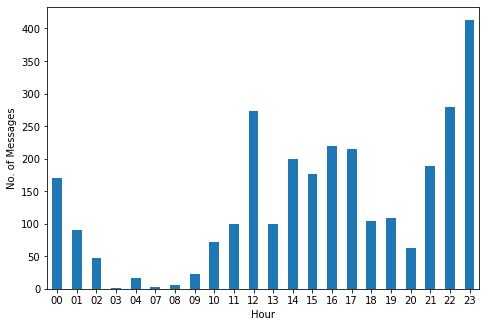

In [60]:
# plotting a graph showing pattern of number of messages distributed over different hours of the day:
hour_pattern = '(\d+):\d+\s+(am|pm|AM|PM)+\s+-\s+\w+\s?\w+?\s?\w+\s?\w+:\s'
hours = re.findall(hour_pattern,data)
hrs=[]
for i in hours:
    if(i[1]=='pm' or i[1]=='PM'):
        if(int(i[0])>=1 and int(i[0])<=11):
            hrs.append(str(int(i[0])+12))
        else:
            hrs.append(i[0])
    else:
        if(int(i[0])>=12):
            hrs.append('00')
        else:
            if(int(i[0])>=1 and int(i[0])<=9):
                hrs.append('0'+i[0])
            else:
                hrs.append(i[0])  
time = pd.DataFrame({'hours':hrs})
busy_hours = time['hours'].value_counts()
busy_hours.sort_index(inplace=True)
plt.axes([1,1,1,0.98])
plt.grid(True)
busy_hours.plot.bar()
plt.xlabel('Hour')
plt.ylabel('No. of Messages')
plt.xticks(rotation=0)
plt.show()
%matplotlib inline

Text(0.5, 1.0, 'Average Message Lengths')

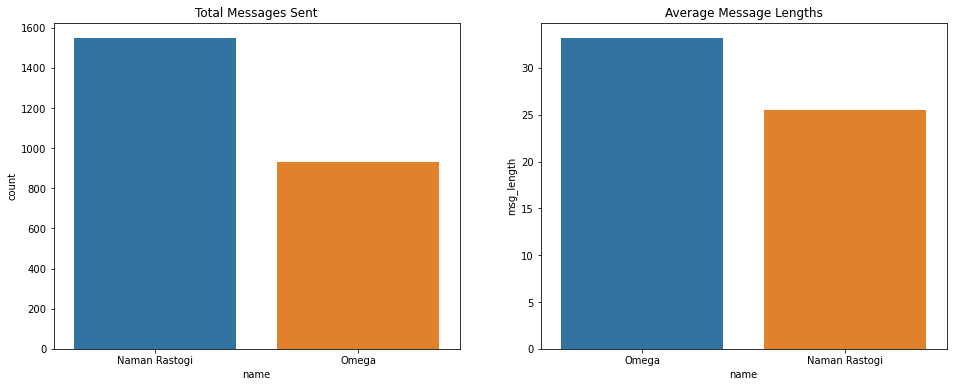

In [61]:
# Countplot of total messages sent
fig, axs = plt.subplots(ncols = 2, figsize = (16, 6))
sns.countplot(x = 'name', data = data_df, order = data_df['name'].value_counts().index, ax=axs[0] )
axs[0].set_title('Total Messages Sent')

# Barplot of average message lengths
data_df['msg_length'] = data_df['messages'].apply(lambda x: len(x))
avg_msg_lengths =data_df.groupby('name').mean().reset_index().sort_values(by = 'msg_length', ascending = False)
sns.barplot(x = 'name', y = 'msg_length', data = avg_msg_lengths, ax = axs[1])
axs[1].set_title('Average Message Lengths')

Text(0.5, 1.0, 'Total Media Sent')

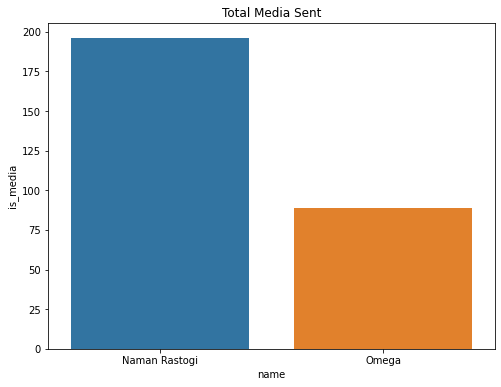

In [62]:
# Barplot of total media count
plt.figure(figsize = (8, 6))
data_df['is_media'] = data_df['messages'].apply(lambda x: 1 if '<Media omitted>' in x else 0)
data_df.groupby('name').sum().reset_index().sort_values(by = 'is_media', ascending = False)[['name', 'is_media']]
total_media_count = data_df.groupby('name').sum().reset_index().sort_values(by = 'is_media', ascending = False)[['name', 'is_media']]
sns.barplot(x = 'name', y = 'is_media', data = total_media_count)
plt.title('Total Media Sent')

Text(0.5, 1.0, 'Total messages sent grouped by month')

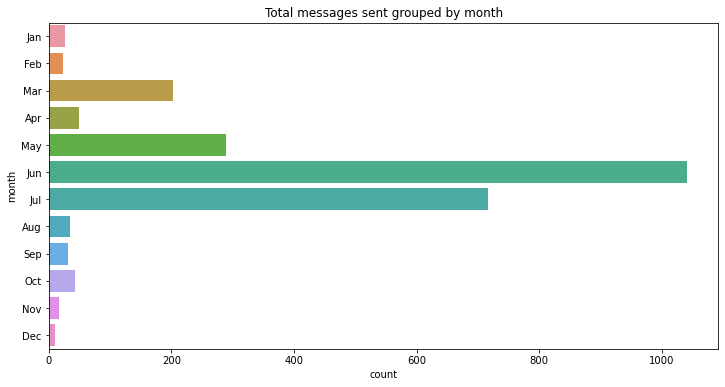

In [63]:
# Total messages sent spanning over a month:
fig, ax = plt.subplots(ncols = 1, figsize = (12, 6))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
grouped_by_month = data_df.groupby('month').sum().reset_index().sort_values(by = 'count', ascending = False)
sns.barplot(x = 'count', y = 'month', data = grouped_by_month, order = months, ax = ax)
ax.set_title('Total messages sent grouped by month')

Text(0.5, 1.0, 'Most Active Hours')

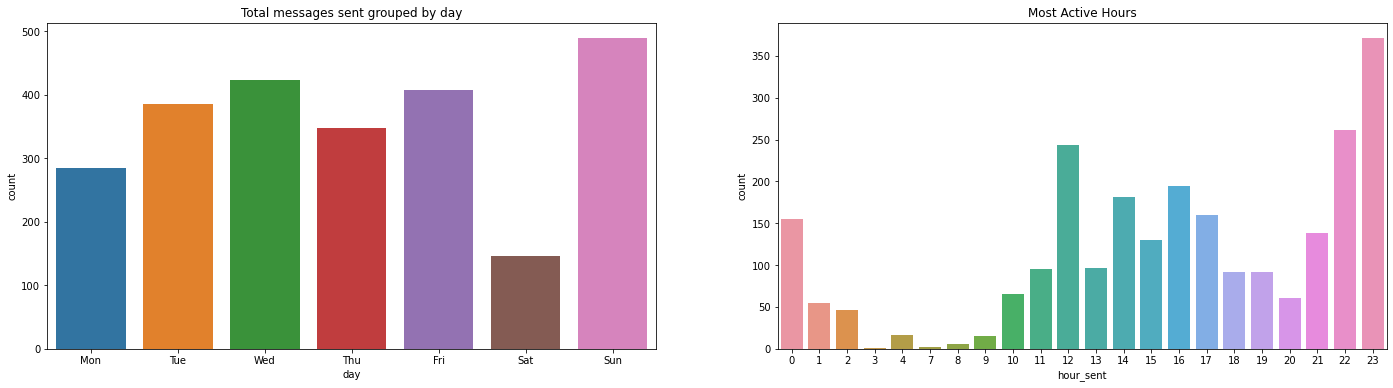

In [64]:
# Total messages spanning over a day and most active hours of talk:
fig, axs = plt.subplots(ncols = 2, figsize = (24, 6))
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
grouped_by_day = data_df.groupby('day').sum().reset_index()[['day', 'count']]
sns.barplot(y = 'count', x = 'day', data = grouped_by_day, order = days, ax = axs[0])
axs[0].set_title('Total messages sent grouped by day')

data_df['hour_sent'] = data_df['datetime'].apply(lambda x: x.hour)
grouped_by_time = data_df.groupby('hour_sent').sum().reset_index().sort_values(by = 'count', ascending = False)
sns.barplot(y = 'count', x = 'hour_sent', data = grouped_by_time, ax = axs[1])
axs[1].set_title('Most Active Hours')

Text(0.5, 1.0, 'Most Active Days')

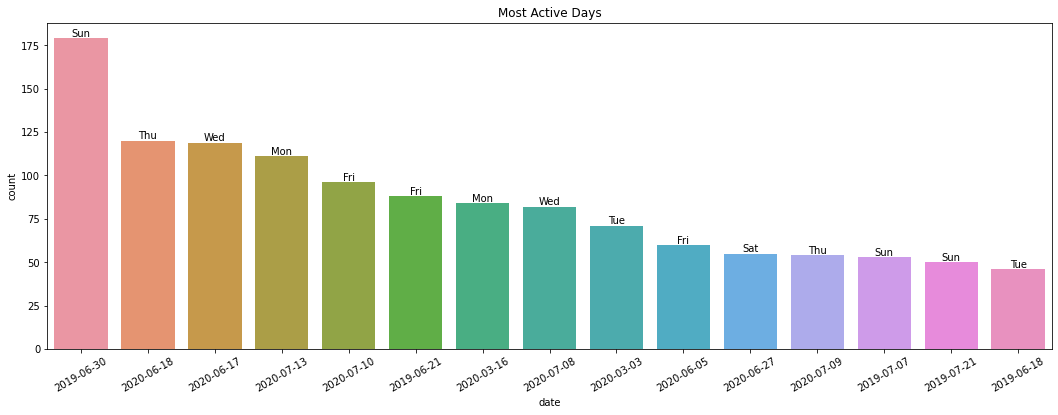

In [65]:
plt.figure(figsize = (18, 6))

grouped_by_date = data_df.groupby('date').sum().reset_index().sort_values(by = 'count', ascending = False).head(15)
grouped_by_date['day'] = grouped_by_date['date'].apply(lambda x: x.strftime('%a'))
ax = sns.barplot(y = 'count', x = 'date', data = grouped_by_date)

# I spent way too long to get the bar annotations to work properly. Thank you again, StackOverflow.
for bar, label in zip(ax.patches, grouped_by_date['day']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x + width/2., height + 1, label, ha="center") 

ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('Most Active Days')